In [1]:
## Let's read a sample audio using librosa
import librosa
audio_file_path = 'UrbanSound8K/dog_bark.wav'
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [2]:
print(librosa_audio_data)

[ 3.4924597e-10  3.4924597e-10  4.6566129e-10 ... -7.9498515e-03
 -7.7366987e-03 -8.0531817e-03]


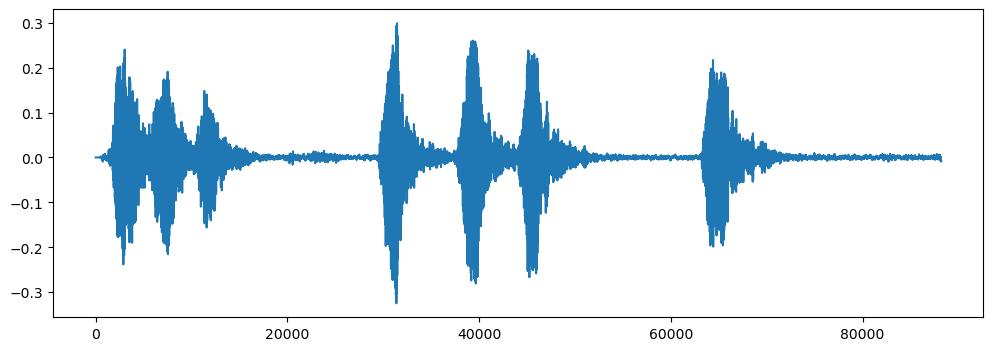

In [3]:
## Let's plot the librosa audio data
import matplotlib.pyplot as plt
# Original audio with 1 channel
plt.figure(figsize=(12,4))
plt.plot(librosa_audio_data)

**Observation**

Here Librosa converts the signal to mono, meaning the channel will always be 1 

In [5]:
## Let's read with scipy
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [6]:
wave_audio

array([[   0,    0],
       [   0,    0],
       [   0,    0],
       ...,
       [-399, -115],
       [-388, -111],
       [-386, -105]], dtype=int16)

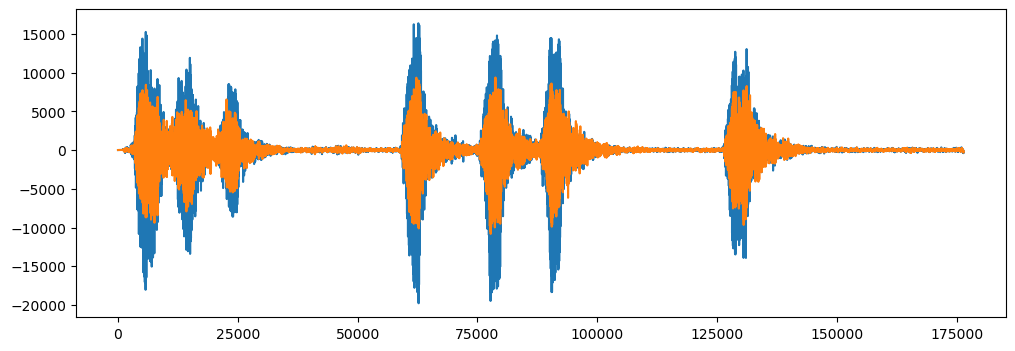

In [7]:
# Original audio with 2 channel
plt.figure(figsize=(12,4))
plt.plot(wave_audio) 

**Extract Features**

Here we will be using Mel-Frequency Cepstral Coefficient(MFCC) from the audio samples. The MFCC Summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. these audio representations will allow us to identify features for classification.

In [9]:
mfcc = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfcc.shape)

(40, 173)


In [10]:
mfcc

array([[-5.7041687e+02, -5.0580988e+02, -4.4661017e+02, ...,
        -4.8128598e+02, -4.7245932e+02, -4.6425366e+02],
       [ 3.2360130e+01,  9.3758621e+01,  1.4270895e+02, ...,
         1.0403226e+02,  1.1474982e+02,  1.1683809e+02],
       [ 2.6088989e+01,  3.4996727e+01,  4.0650406e+01, ...,
         1.1899885e+01,  1.7138729e+01,  1.3889361e+01],
       ...,
       [ 5.9291601e-01,  2.7261472e+00, -2.6107330e+00, ...,
        -2.7341046e+00, -3.7576494e+00, -5.8963108e+00],
       [-1.3069378e+00, -2.1206617e+00, -9.1924369e-01, ...,
        -1.2278577e+00, -3.3734822e+00, -4.1975555e+00],
       [-2.0638499e+00, -2.9027803e+00,  2.7278179e-01, ...,
        -1.3872120e+00, -3.3259065e+00, -8.4930527e-01]], dtype=float32)

In [11]:
### Extracting MFCC'S for every audio file
import pandas as pd
import os
import librosa

audio_dataset_path = 'UrbanSound8K/audio/'
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [12]:
metadata["class"].unique().shape

(10,)

In [13]:
def feature_extractor(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

In [14]:
import numpy as np
from tqdm import tqdm
import resampy
## Now we iterate through every audio file and extract features
## using Mel-Frequency Cepstral Coefficients
extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels = row["class"]
    data = feature_extractor(file_name)
    extracted_features.append([data, final_class_labels])

3555it [02:38, 21.67it/s]C:\Users\yasba\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8323it [06:07, 31.90it/s]C:\Users\yasba\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
8327it [06:07, 33.05it/s]C:\Users\yasba\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [06:24, 22.72it/s]


In [15]:
extracted_features_df = pd.DataFrame(extracted_features, columns=["Features","Class"])
extracted_features_df.head()

,Features,Class
0,"[-211.93698, 62.581207, -122.81313, -60.745293...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578068, 43.19586, ...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690277,...",children_playing


In [16]:
## Split the dataset into independent and dependent dataset
X = np.array(extracted_features_df["Features"].tolist())
y = np.array(extracted_features_df["Class"].tolist())

In [17]:
X.shape, y.shape

((8732, 40), (8732,))

In [18]:
## Label Encoding 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
y.shape

(8732,)

In [19]:
## Train test Splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6985, 40), (1747, 40), (6985,), (1747,))

# Model Creation

In [22]:
import tensorflow as tf

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [24]:
import warnings
warnings.filterwarnings("ignore")
model = Sequential()

## First Layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation("relu"))
model.add(Dropout(0.5))

## Second Layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

## Third Layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

## Final Layer
model.add(Dense(10))
model.add(Activation("softmax"))

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │           4,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,410 (177.38 KB)

 Trainable params: 45,410 (177.38 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
## Use categorical_crossentropy if the target variable is label encoded
## Else use sparse_categorical_crossentropy if target variable is onehot encode or other format

In [78]:
## Training my model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

# num_classes = 10

# # One-hot encode the targets
# y_train = to_categorical(y_train, num_classes)
# y_test = to_categorical(y_test, num_classes)

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.keras', verbose=1, save_best_only=True)

start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test,y_test), callbacks=[checkpointer])

duration = datetime.now() - start
print("Training completed in time: ",duration)

Epoch 1/100
215/219 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6847 - loss: 0.9794
Epoch 1: val_loss improved from inf to 0.71705, saving model to saved_models/audio_classification.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6845 - loss: 0.9794 - val_accuracy: 0.7819 - val_loss: 0.7171
Epoch 2/100
215/219 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6854 - loss: 0.9348
Epoch 2: val_loss improved from 0.71705 to 0.69070, saving model to saved_models/audio_classification.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6854 - loss: 0.9347 - val_accuracy: 0.7768 - val_loss: 0.6907
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6866 - loss: 0.9476
Epoch 3: val_loss did not improve from 0.69070
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6866 - loss: 0.9475 - val_accuracy: 0.7848 - val_loss: 0.6909
Epoch 4/100
211/219 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6680 - loss: 0.9933
Epoch 4: val_loss did not improve from 0.6

In [80]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy[1])

0.8042358160018921


## Testing Some Test Audio Data

Steps

- Preprocess the new audio data
- predict the classes
- invere transform the predicted label

In [82]:
filename = "UrbanSound8k/Vehicle_engine.wav"
audio, sample_rate = librosa.load(filename)
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_sacled_features = np.mean(mfccs_features.T, axis = 0)

print(mfccs_sacled_features)
mfccs_sacled_features = mfccs_sacled_features.reshape(1,-1)
print(mfccs_sacled_features)
print(mfccs_sacled_features.shape)
predicted_label = model.predict(mfccs_sacled_features)
print(predicted_label)
# Convert probabilities to class indices
predicted_indices = np.argmax(predicted_label, axis=1)
prediction_class = le.inverse_transform(predicted_indices)
# classes[prediction_class]
print("This sound is of:",prediction_class)

[-141.93561     166.08955     -27.16938      29.21639      -0.8035423
   17.407234      9.9649515     8.274854      7.826444     10.795426
   -1.6256998    10.069982      4.0228114     1.4971251     4.317575
    8.45127       1.9284961     5.066989      2.3178167     4.3121114
    2.9932947     4.1397176     2.2665653     4.6423426     6.9269195
    4.6499977     5.066665      5.2290535     4.2991076     5.6840963
    1.877131      1.9597065     0.63664204    1.6418138     0.96286523
    2.6194706     1.1792985     1.6613876     2.7393994     3.9143522 ]
[[-141.93561     166.08955     -27.16938      29.21639      -0.8035423
    17.407234      9.9649515     8.274854      7.826444     10.795426
    -1.6256998    10.069982      4.0228114     1.4971251     4.317575
     8.45127       1.9284961     5.066989      2.3178167     4.3121114
     2.9932947     4.1397176     2.2665653     4.6423426     6.9269195
     4.6499977     5.066665      5.2290535     4.2991076     5.6840963
     1.877131  